In [6]:
import requests
import numpy as np
import pandas as pd
import sklearn.ensemble as sk
import sklearn
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
train=pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


1. Creat three train data subsets: (1) with all features (2) without age
===

In [8]:
train1=train[['PassengerId','Pclass','Sex','Age','SibSp','Survived']].copy()
train2=train[['PassengerId','Pclass','Sex','SibSp','Survived']].copy()
train1=train1.dropna()
train2=train2.dropna()
print train1.shape
print train2.shape
print train.shape

(714, 6)
(891, 5)
(891, 12)


In [9]:
sex_dic={'male':0,'female':1}
embarked_dic={'S':0,'C':1,'Q':2}
def rename(df):
    df['Sex']=map(lambda x: sex_dic[x],df['Sex'])
    #df['Embarked']=map(lambda x: embarked_dic[x],df['Embarked'])
    return df
train1=rename(train1)
train2=rename(train2)

In [10]:
sub_train1,sub_val1=sklearn.cross_validation.train_test_split(train1,test_size=0.33,random_state=99)
sub_train1=pd.DataFrame(sub_train1)
sub_train1.columns=train1.columns
sub_val1=pd.DataFrame(sub_val1)
sub_val1.columns=train1.columns
print sub_train1.shape
print sub_val1.shape

sub_train2,sub_val2=sklearn.cross_validation.train_test_split(train2,test_size=0.33,random_state=99)
sub_train2=pd.DataFrame(sub_train2)
sub_train2.columns=train2.columns
sub_val2=pd.DataFrame(sub_val2)
sub_val2.columns=train2.columns
print sub_train2.shape
print sub_val2.shape

(478, 6)
(236, 6)
(596, 5)
(295, 5)


2. Import test data and split into three subsets: test1,test2
===

In [11]:
test=pd.read_csv('test.csv')
test_sub=test[['PassengerId','Pclass','Sex','Age','SibSp']].copy()
print test_sub.shape
test_sub.head()

(418, 5)


,PassengerId,Pclass,Sex,Age,SibSp
0,892,3,male,34.5,0
1,893,3,female,47.0,1
2,894,2,male,62.0,0
3,895,3,male,27.0,0
4,896,3,female,22.0,1


In [12]:
test1=test_sub
test1=test1.dropna()
test1=rename(test1)
print test1.shape
test1.head()

(332, 5)


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PassengerId,Pclass,Sex,Age,SibSp
0,892,3,0,34.5,0
1,893,3,1,47.0,1
2,894,2,0,62.0,0
3,895,3,0,27.0,0
4,896,3,1,22.0,1


In [13]:
test_nan=test_sub[test_sub.isnull().any(axis=1)]
print test_nan.shape

test2=test_nan.drop('Age',axis=1)
test2=test2.dropna()
test2=rename(test2)
print test2.shape

print test.shape[0]==test1.shape[0]+test2.shape[0]

(86, 5)
(86, 4)
True


In [14]:
test2.head()

,PassengerId,Pclass,Sex,SibSp
10,902,3,0,0
22,914,1,1,0
29,921,3,0,2
33,925,3,1,1
36,928,3,1,0


3. Train the train data
===

In [16]:
col=[['Pclass','Sex','Age','SibSp','intercept'],
      ['Pclass','Sex','SibSp','intercept']]
def logistic_regression_train(train,i,col=col):
    train['intercept']=1.0
    cols=col[i-1]
    logit=sm.Logit(train['Survived'],train[cols])
    result=logit.fit()
    paras=result.params
    return paras

(1) subset 1
---

In [17]:
paras1=logistic_regression_train(sub_train1,1)
paras1

Optimization terminated successfully.
         Current function value: 0.425889
         Iterations 6


Pclass      -1.422218
Sex          2.687388
Age         -0.034991
SibSp       -0.498093
intercept    2.742212
dtype: float64

(2) subset 2
---

In [18]:
paras2=logistic_regression_train(sub_train2,2)
paras2

Optimization terminated successfully.
         Current function value: 0.434280
         Iterations 6


Pclass      -0.983711
Sex          3.049841
SibSp       -0.318048
intercept    0.741856
dtype: float64

4. Validation and test
===

In [19]:
from math import exp
def probability(row,paras):
    z=paras[len(paras)-1]
    for i in np.arange(0,len(paras)-1):
        z=z+row[i]*paras[i]
    return 1/(1+exp(-1.0*z))

(1) subset 1
----

In [20]:
compare=sub_val1[['Pclass','Sex','Age','SibSp']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras1))
sub_val1['Pred']=pred

*****
compute confusion matrix with gender considered
*****

In [21]:
temp=sub_val1[['Sex','Survived','Pred']].copy()
tempmale=temp[temp['Sex']==0]
tempfemale=temp[temp['Sex']==1]

In [22]:
def survive_cm(pp,df):
    temp=df[['Survived','Pred']].copy()
    temp['TF']=temp['Pred']>=pp
    cm=sklearn.metrics.confusion_matrix(temp['Survived'],temp['TF'])
    return cm

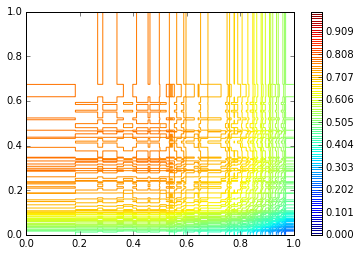

In [23]:
m1=[]
xlist=np.linspace(0,1,1000)
m1=map(lambda x: survive_cm(x,tempmale),xlist)
m2=[]
ylist=np.linspace(0,1,1000)
m2=map(lambda x: survive_cm(x,tempfemale),ylist)

mm=[]
for ii in m1:
    for jj in m2:
        cm=ii+jj
        mm.append((cm[0,0]+cm[1,1])*1.0/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0]))
        
mmm=np.reshape(mm, (-1, len(xlist)))


contour_levels = np.linspace(0,1,100)
plt.contour(xlist,ylist,mmm,levels=contour_levels)
plt.colorbar()
plt.show()

In [25]:
matrix=np.asmatrix(mmm)
#print matrix.argmax()
#print matrix.argmax(0)
#print matrix.argmax(1)
print np.max(matrix)
ppm=xlist[461]
ppf=xlist[0]
print matrix[461,0]

0.796610169492
0.796610169492


In [26]:
compare=test1[['Pclass','Sex','Age','SibSp']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras1))
test1['Pred']=pred
testmale=test1[test1['Sex']==0]
testfemale=test1[test1['Sex']==1]
testmale['Survived']=1*(testmale['Pred']>=ppm)
testfemale['Survived']=1*(testfemale['Pred']>=ppf)
test1=(pd.concat([testmale,testfemale])).sort('PassengerId')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [27]:
test1.head()

,PassengerId,Pclass,Sex,Age,SibSp,Pred,Survived
0,892,3,0,34.5,0,0.061132,0
1,893,3,1,47.0,1,0.272945,1
2,894,2,0,62.0,0,0.093496,0
3,895,3,0,27.0,0,0.078046,0
4,896,3,1,22.0,1,0.473786,1


(2) subset 2
---

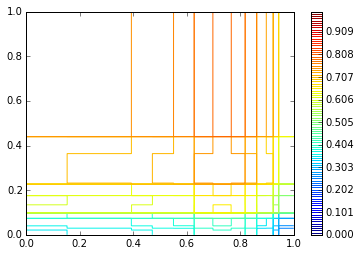

In [28]:
compare=sub_val2[['Pclass','Sex','SibSp']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras2))
sub_val2['Pred']=pred

temp=sub_val2[['Sex','Survived','Pred']].copy()
tempmale=temp[temp['Sex']==0]
tempfemale=temp[temp['Sex']==1]

m1=[]
xlist=np.linspace(0,1,1000)
m1=map(lambda x: survive_cm(x,tempmale),xlist)
m2=[]
ylist=np.linspace(0,1,1000)
m2=map(lambda x: survive_cm(x,tempfemale),ylist)

mm=[]
for ii in m1:
    for jj in m2:
        cm=ii+jj
        mm.append((cm[0,0]+cm[1,1])*1.0/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0]))
        
mmm=np.reshape(mm, (-1, len(xlist)))


contour_levels = np.linspace(0,1,100)
plt.contour(xlist,ylist,mmm,levels=contour_levels)
plt.colorbar()
plt.show()

In [30]:
matrix=np.asmatrix(mmm)
#print matrix.argmax()
#print matrix.argmax(0)
#print matrix.argmax(1)
print np.max(matrix)
ppm=xlist[440]
ppf=xlist[698]
print matrix[440,698]

0.803389830508
0.803389830508


In [31]:
compare=test2[['Pclass','Sex','SibSp']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras2))
test2['Pred']=pred
testmale=test2[test2['Sex']==0]
testfemale=test2[test2['Sex']==1]
testmale['Survived']=1*(testmale['Pred']>=ppm)
testfemale['Survived']=1*(testfemale['Pred']>=ppf)
test2=(pd.concat([testmale,testfemale])).sort('PassengerId')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
test2.head()

,PassengerId,Pclass,Sex,SibSp,Pred,Survived
10,902,3,0,0,0.098921,0
22,914,1,1,0,0.943106,1
29,921,3,0,2,0.054921,0
33,925,3,1,1,0.627736,0
36,928,3,1,0,0.698584,0


5.Results
===

In [33]:
result1=test1[['PassengerId','Survived']].copy()
result2=test2[['PassengerId','Survived']].copy()

In [34]:
frames=[result1,result2]
results=pd.concat(frames)

In [35]:
results.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
results.to_csv('logistic_regression_gender_drop2_result.csv',header=True,index=False)

In [36]:
print results.shape

(418, 2)
